In [1]:
try:
  from pathlib import Path
except ImportError:
  from pathlib2 import Path  # python 2 backport

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import umap
import hdbscan

import MDAnalysis as mda

#from sklearn.externals import joblib
import joblib


C:\Users\hrach\anaconda3\envs\Inertia\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\hrach\anaconda3\envs\Inertia\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\hrach\anaconda3\envs\Inertia\lib\site-packages\umap\distances.py:1086: NumbaD

In [2]:
from MDAnalysis.analysis.distances import distance_array

In [3]:
systems = ["100pc_tyl", "75tyl_25TX", "50tyl_50TX", "25tyl_75TX"]


In [6]:
# atom_names = """name C102 C53 C7"""  # 3 points
atom_names = """name C7 C36 C70 C102"""  # 4 points
# atom_names = """resname TY79 and name C5 C35 C53 C71 C103"""  # 5 points


result = np.array([])
p = [0]
for s in systems:
    skip = 1
    structure = f'{directory}/{s}/centered.gro'
    trajectory = f'{directory}/{s}/centered.xtc'
    try:
        u = mda.Universe(structure, trajectory)
    except:
        u = mda.Universe(structure, f'{directory}/{s}/centered_whole_skip_20.xtc')
        skip = 5
    ag = u.select_atoms(atom_names)
    n_frames = len(u.trajectory)
    n_res = ag.n_residues
    print(n_res)

    positions = []
    for _ in u.trajectory:
        positions.append(ag.positions)
    positions = np.array(positions)
    positions.shape = (n_frames, n_res, -1, 3)
    d = []
    p.append(n_frames)
    
    for i, frame in enumerate(positions[::skip]):
        for prot in frame:
            dists = distance_array(prot, prot)
            d.append(dists)
    d = np.array(d)
    d.shape = (-1, 16)
    if len(result) == 0:
        result = d
    else:
        result = np.concatenate((result, d))

21
16


Exception ignored in: <function ReaderBase.__del__ at 0x000001C492F996C0>
Traceback (most recent call last):
  File "C:\Users\hrach\anaconda3\envs\Inertia\lib\site-packages\MDAnalysis\coordinates\base.py", line 2200, in __del__
    self.close()
  File "C:\Users\hrach\anaconda3\envs\Inertia\lib\site-packages\MDAnalysis\coordinates\XDR.py", line 186, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


11
5


In [7]:
result.shape

(36383, 16)

In [42]:
np.save(f"{directory}/tyl_input_distances_4p.npy", result)


# Input/Output files

In [4]:
# Trajectory
SYSTEM_NAME = "100pc_tyl"
directory = r"E:\C_backup\Documents-2\Documents\Simulations\tyloxapol_tx\tyl_7"
structure = f'{directory}/{SYSTEM_NAME}/centered.gro'
trajectory = f'{directory}/{SYSTEM_NAME}/centered.xtc'

In [328]:
# Distances
# atom_names = """name C7 C34 C51 C68 C85 C102"""
atom_names = """name C34 C68 C102"""

u = mda.Universe(structure, trajectory)
ag = u.select_atoms(atom_names)

positions = []

for _ in u.trajectory:
    positions.append(ag.positions)



In [16]:

# np.save(f"{directory}/{SYSTEM_NAME}/tyl_100_distances.npy", d)

# input_distances = f"{directory}/{SYSTEM_NAME}/tyl_100_distances.npy"
ag.n_residues

21

In [10]:
positions = np.array(positions)

In [11]:
positions.shape = (730, 21, -1, 3)

In [12]:
positions[0][0]

array([[44.030003, 53.520004, 56.63    ],
       [42.61    , 47.060005, 52.110004],
       [49.020004, 39.06    , 52.700005]], dtype=float32)

In [13]:
d = []

for frame in positions:
    for prot in frame:
        dists = distance_array(prot, prot)
        d.append(dists)
        
d = np.array(d)
d.shape = (-1, 9)

# np.save(f"{directory}/{SYSTEM_NAME}/tyl_100_distances.npy", d)



In [4]:
input_distances = f"{directory}/{SYSTEM_NAME}/tyl_100_distances.npy"  # Normalize

In [5]:
output_embedding = '2d_embedding.joblib'
output_embedded_distances = 'embedded_distances.npy'

output_clusters = 'clusters.joblib'
output_cluster_labels = 'cluster_labels.npy'

270141

# Load data

In [164]:
#u = mda.Universe(structure, directory)
input_distances = f"{directory}/tyl_input_distances_4p.npy"  # Normalize
distances = np.load(input_distances)


In [127]:
print(distances[0])
print(distances[1])

[ 0.          7.26527388 14.13974316 18.92627493  7.26527388  0.
  8.37990651 15.09803837 14.13974316  8.37990651  0.          7.65853308
 18.92627493 15.09803837  7.65853308  0.        ]
[ 0.          6.85745303 15.56146356 21.57174949  6.85745303  0.
  8.89385153 15.26589487 15.56146356  8.89385153  0.          7.26801942
 21.57174949 15.26589487  7.26801942  0.        ]


In [171]:
a = 0.2
# distance_ex = np.exp(a * distances) - 1
distance_ex = distances + np.exp(a * distances) - 1

distance_ex /= distance_ex.max()

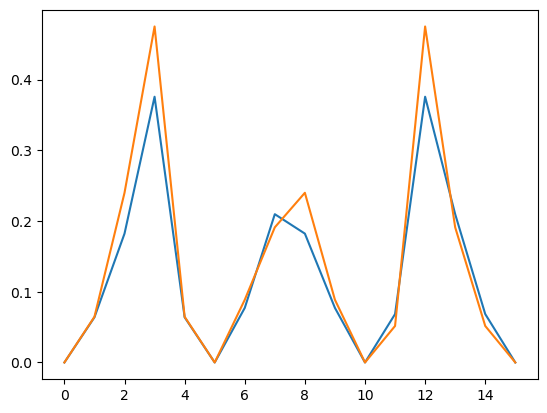

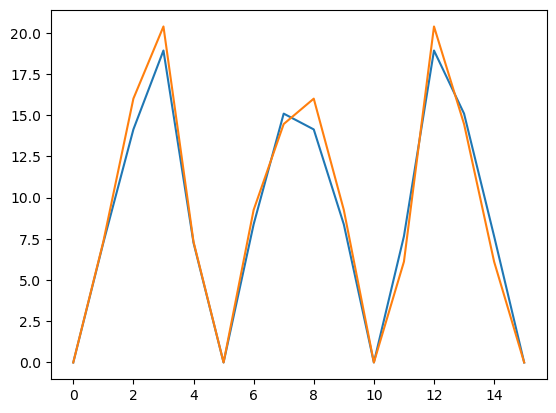

In [172]:
plt.plot(distance_ex[0])
plt.plot(distance_ex[100])
# plt.plot(distances[0] - distances[20000])
plt.show()
plt.plot(distances[0])
plt.plot(distances[100])
plt.show()

In [174]:
distances = distance_ex

In [13]:
distances_norm = distances / distances.max()

In [7]:
distances /= distances.max()

In [8]:
distances.shape

(36383, 16)

# TSNE

In [109]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=250, early_exaggeration=1, random_state=42, perplexity=500)
embedded = tsne.fit_transform(distances)

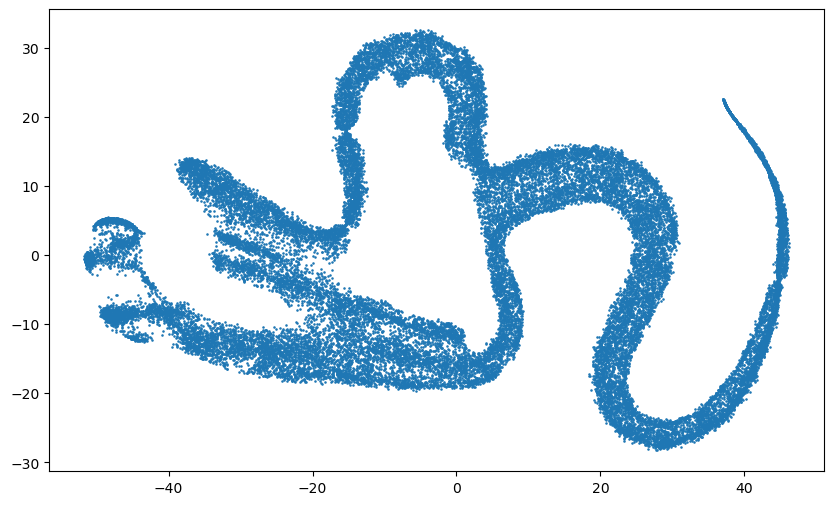

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(embedded[:, 0], embedded[:, 1], s=0.7)

# Scan of n_neighbours hyperparameter

In [103]:
output_embedded_distances = 'umap_files/NN_scan_step2/NN{}_embedded_distances.npy'
output_cluster_labels = 'umap_files/NN_scan_step2/NN{}_cluster_labels.npy'
output_png = 'umap_files/NN_scan_step2/NN{}_clusters.png'

In [104]:
n_neighbours = np.arange(4, 31, 2)

C:\Users\hrach\AppData\Local\Temp\ipykernel_6628\3886436959.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for nn in tqdm(n_neighbours):


  0%|          | 0/14 [00:00<?, ?it/s]

UMAP(min_dist=0.0, n_neighbors=4, random_state=42, verbose=True)
Tue Mar  5 18:06:02 2024 Construct fuzzy simplicial set
Tue Mar  5 18:06:02 2024 Finding Nearest Neighbors
Tue Mar  5 18:06:02 2024 Building RP forest with 15 trees
Tue Mar  5 18:06:03 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:06:03 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:06:03 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:06:57 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


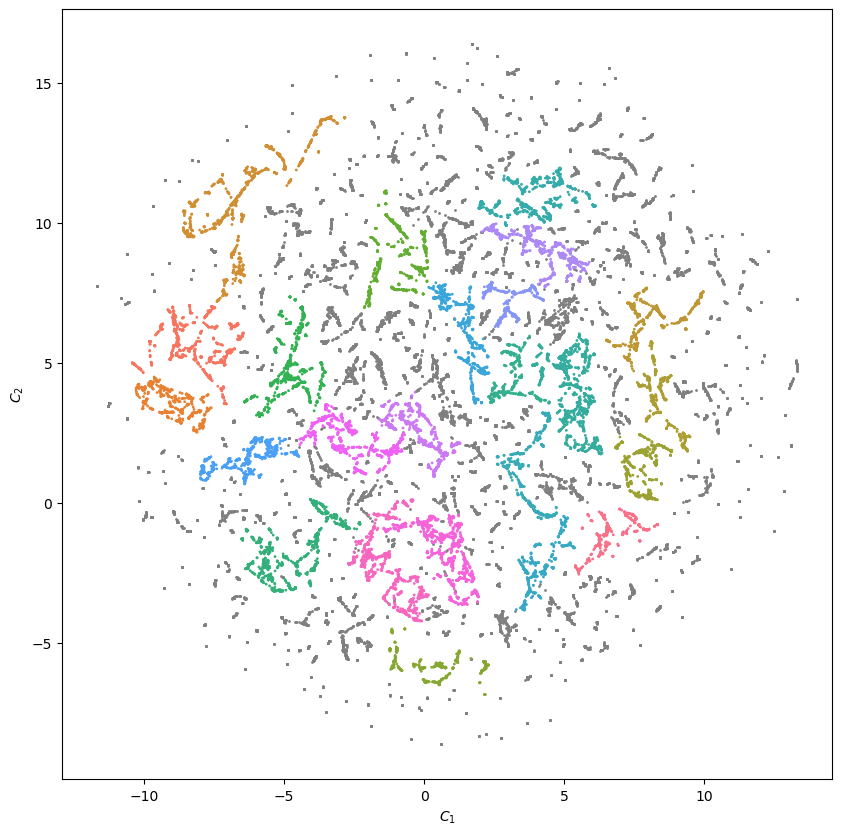

UMAP(min_dist=0.0, n_neighbors=6, random_state=42, verbose=True)
Tue Mar  5 18:07:00 2024 Construct fuzzy simplicial set
Tue Mar  5 18:07:00 2024 Finding Nearest Neighbors
Tue Mar  5 18:07:00 2024 Building RP forest with 15 trees
Tue Mar  5 18:07:00 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:07:01 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:07:01 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:07:35 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


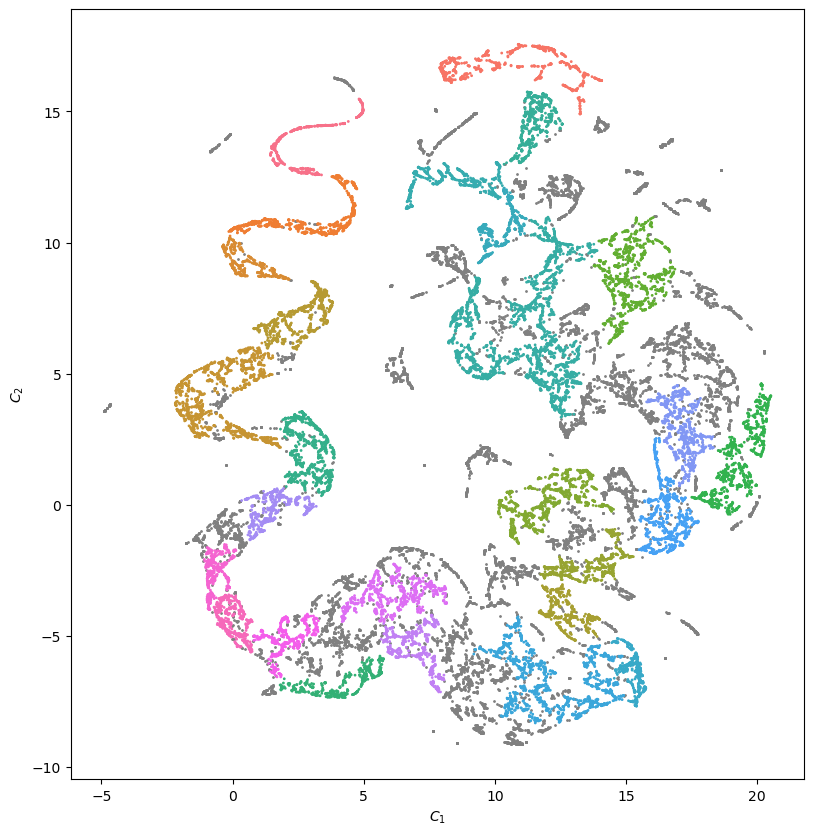

UMAP(min_dist=0.0, n_neighbors=8, random_state=42, verbose=True)
Tue Mar  5 18:07:37 2024 Construct fuzzy simplicial set
Tue Mar  5 18:07:37 2024 Finding Nearest Neighbors
Tue Mar  5 18:07:37 2024 Building RP forest with 15 trees
Tue Mar  5 18:07:37 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:07:38 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:07:38 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:08:11 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


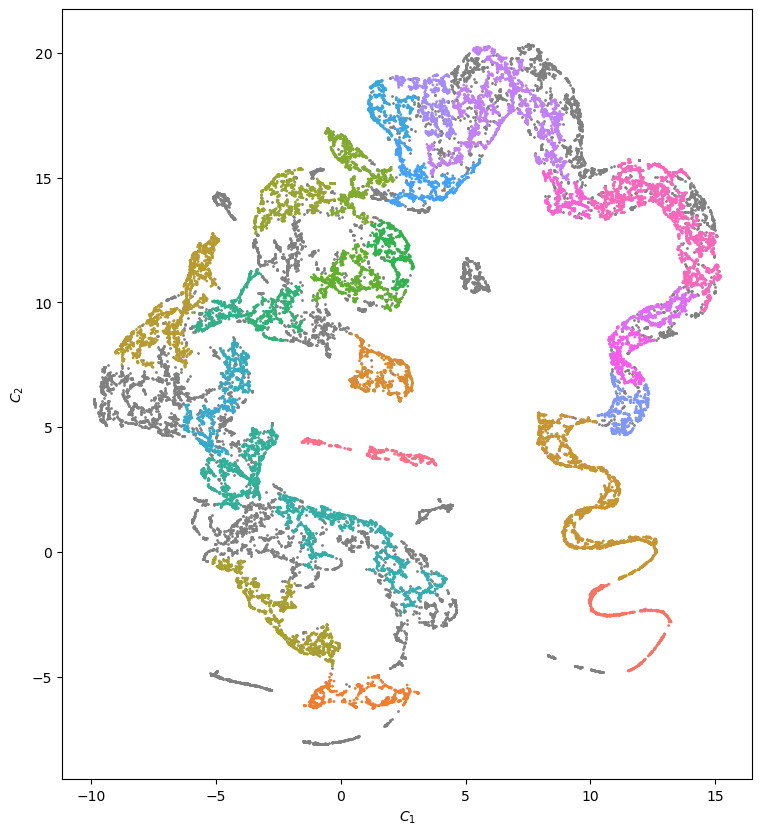

UMAP(min_dist=0.0, n_neighbors=10, random_state=42, verbose=True)
Tue Mar  5 18:08:14 2024 Construct fuzzy simplicial set
Tue Mar  5 18:08:14 2024 Finding Nearest Neighbors
Tue Mar  5 18:08:14 2024 Building RP forest with 15 trees
Tue Mar  5 18:08:14 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:08:14 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:08:15 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:08:48 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


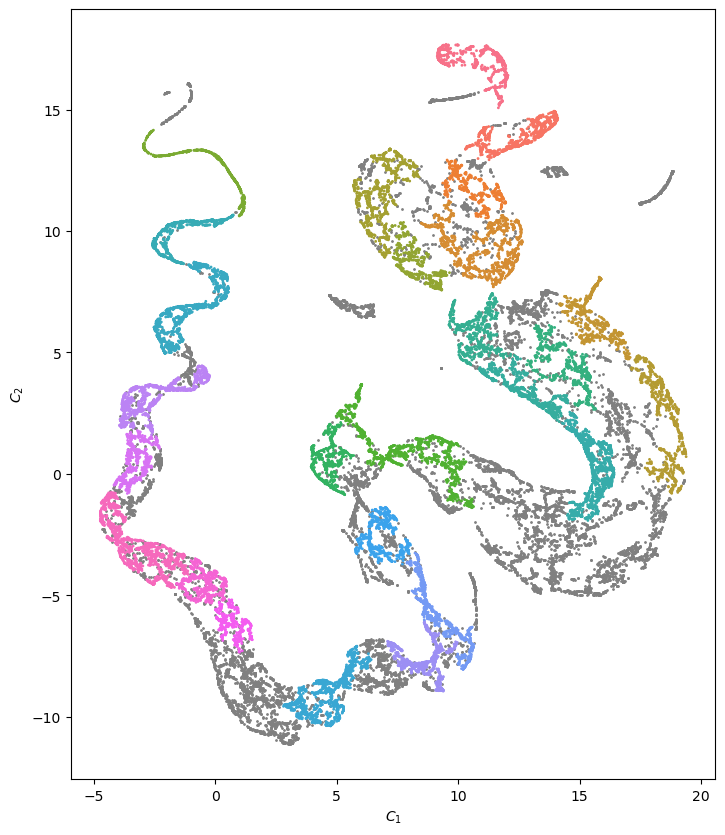

UMAP(min_dist=0.0, n_neighbors=12, random_state=42, verbose=True)
Tue Mar  5 18:08:50 2024 Construct fuzzy simplicial set
Tue Mar  5 18:08:50 2024 Finding Nearest Neighbors
Tue Mar  5 18:08:50 2024 Building RP forest with 15 trees
Tue Mar  5 18:08:50 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:08:51 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:08:51 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:09:23 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


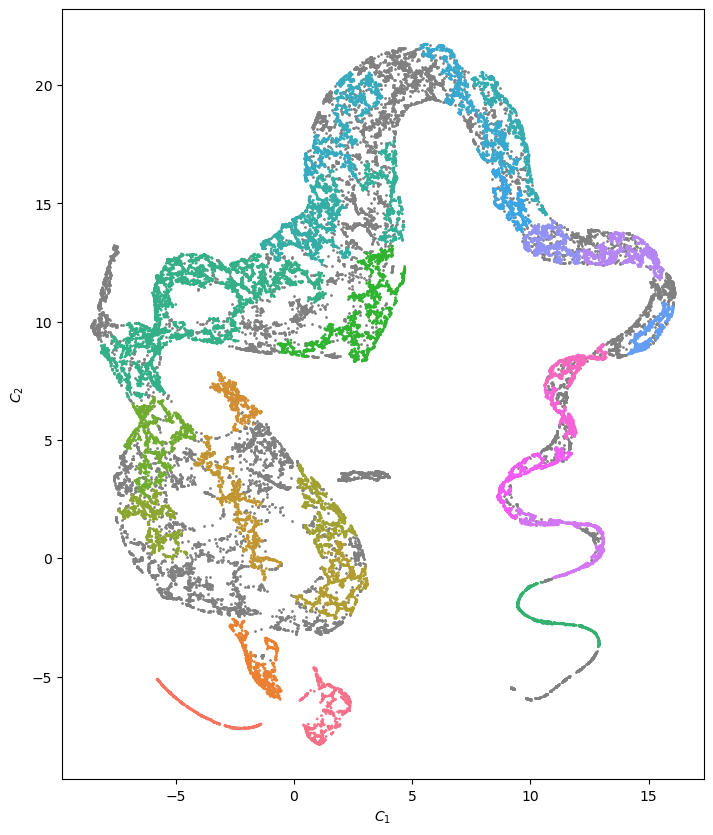

UMAP(min_dist=0.0, n_neighbors=14, random_state=42, verbose=True)
Tue Mar  5 18:09:25 2024 Construct fuzzy simplicial set
Tue Mar  5 18:09:25 2024 Finding Nearest Neighbors
Tue Mar  5 18:09:25 2024 Building RP forest with 15 trees
Tue Mar  5 18:09:25 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:09:26 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:09:26 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:10:01 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


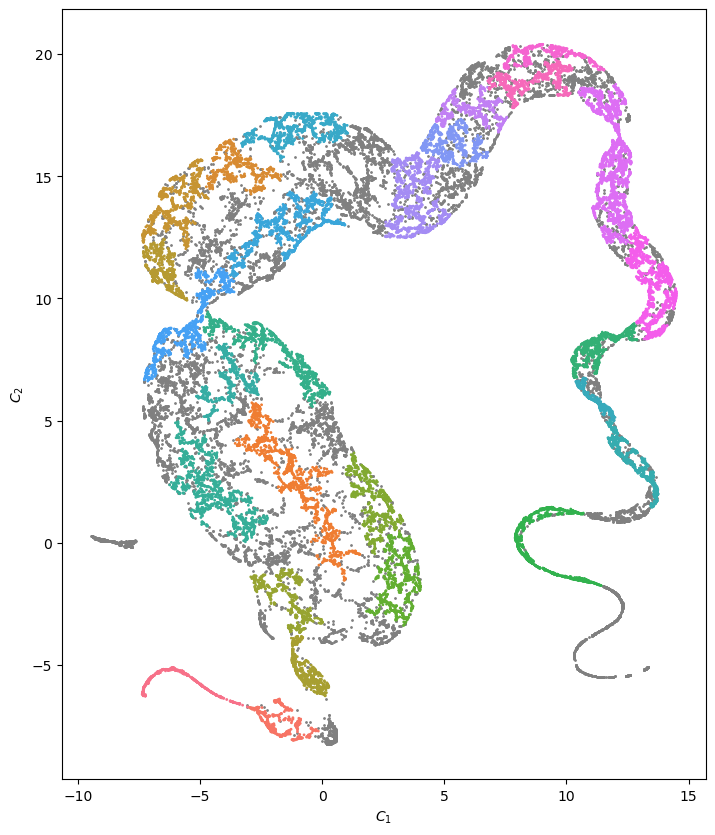

UMAP(min_dist=0.0, n_neighbors=16, random_state=42, verbose=True)
Tue Mar  5 18:10:04 2024 Construct fuzzy simplicial set
Tue Mar  5 18:10:04 2024 Finding Nearest Neighbors
Tue Mar  5 18:10:04 2024 Building RP forest with 15 trees
Tue Mar  5 18:10:04 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:10:04 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:10:05 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:10:40 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


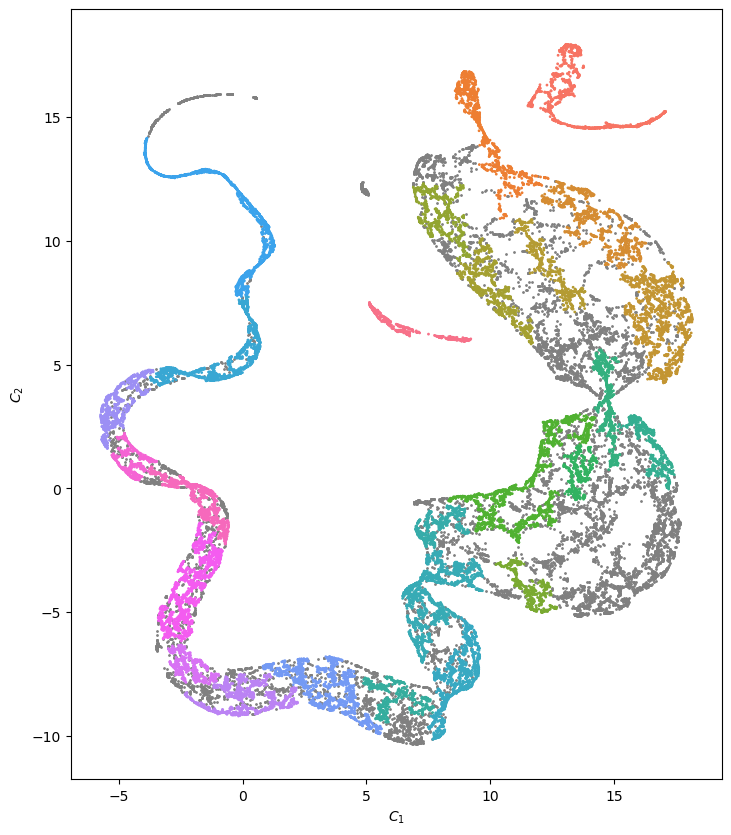

UMAP(min_dist=0.0, n_neighbors=18, random_state=42, verbose=True)
Tue Mar  5 18:10:42 2024 Construct fuzzy simplicial set
Tue Mar  5 18:10:42 2024 Finding Nearest Neighbors
Tue Mar  5 18:10:42 2024 Building RP forest with 15 trees
Tue Mar  5 18:10:42 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:10:43 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:10:44 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:11:18 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


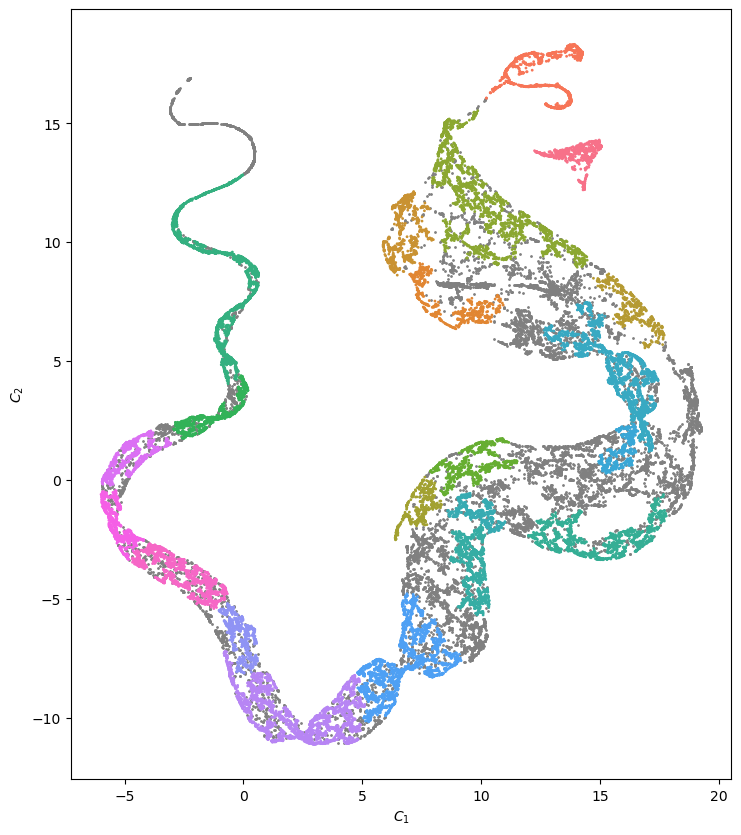

UMAP(min_dist=0.0, n_neighbors=20, random_state=42, verbose=True)
Tue Mar  5 18:11:21 2024 Construct fuzzy simplicial set
Tue Mar  5 18:11:21 2024 Finding Nearest Neighbors
Tue Mar  5 18:11:21 2024 Building RP forest with 15 trees
Tue Mar  5 18:11:21 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:11:22 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:11:22 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:11:57 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


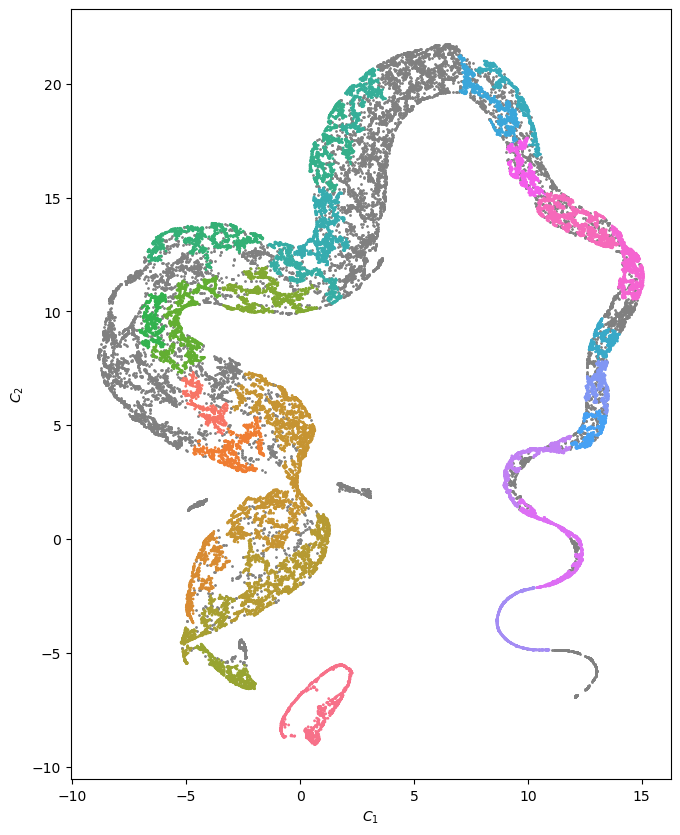

UMAP(min_dist=0.0, n_neighbors=22, random_state=42, verbose=True)
Tue Mar  5 18:12:00 2024 Construct fuzzy simplicial set
Tue Mar  5 18:12:00 2024 Finding Nearest Neighbors
Tue Mar  5 18:12:00 2024 Building RP forest with 15 trees
Tue Mar  5 18:12:00 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:12:01 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:12:01 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:12:39 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


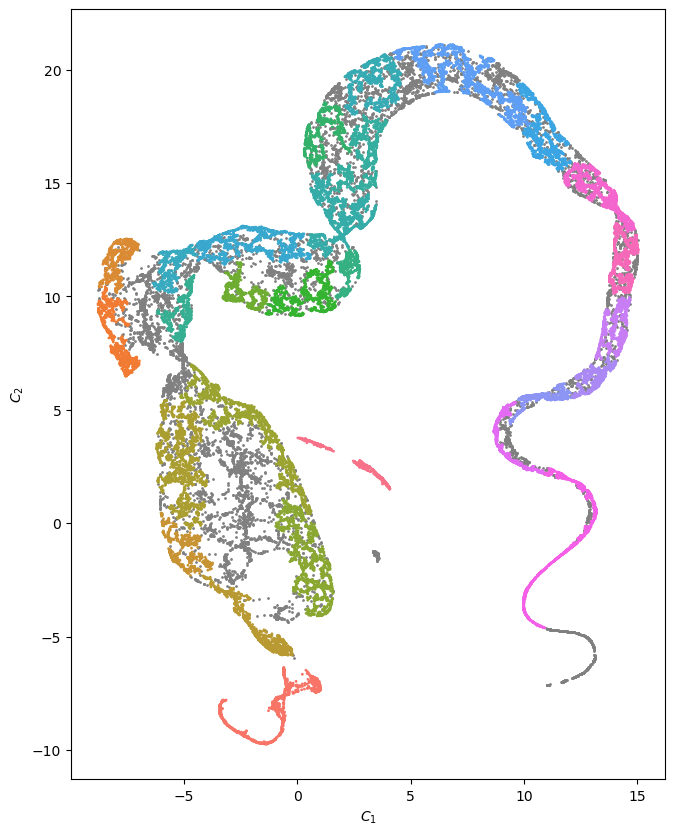

UMAP(min_dist=0.0, n_neighbors=24, random_state=42, verbose=True)
Tue Mar  5 18:12:41 2024 Construct fuzzy simplicial set
Tue Mar  5 18:12:41 2024 Finding Nearest Neighbors
Tue Mar  5 18:12:41 2024 Building RP forest with 15 trees
Tue Mar  5 18:12:42 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:12:43 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:12:43 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:13:20 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


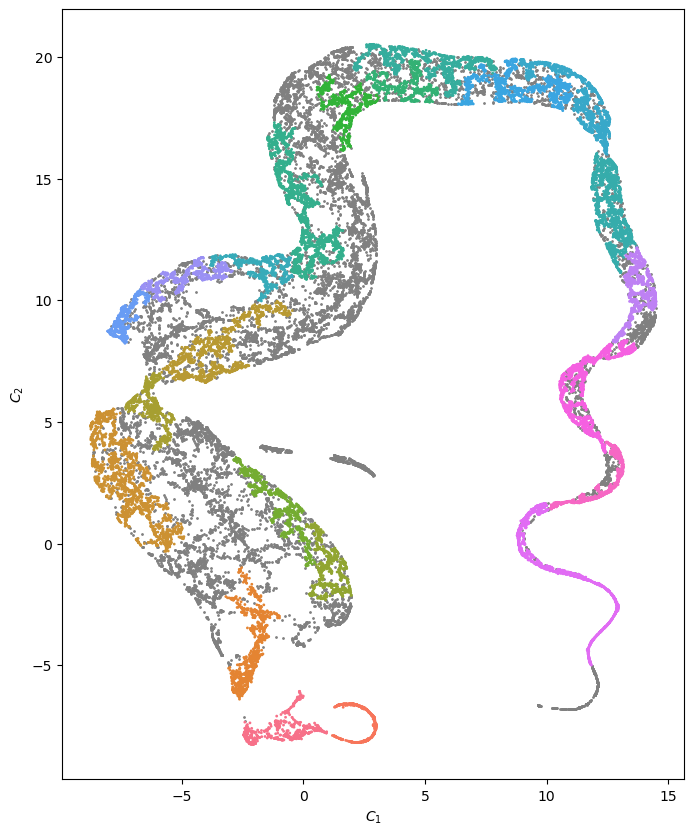

UMAP(min_dist=0.0, n_neighbors=26, random_state=42, verbose=True)
Tue Mar  5 18:13:23 2024 Construct fuzzy simplicial set
Tue Mar  5 18:13:23 2024 Finding Nearest Neighbors
Tue Mar  5 18:13:23 2024 Building RP forest with 15 trees
Tue Mar  5 18:13:23 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:13:24 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:13:25 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:14:03 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


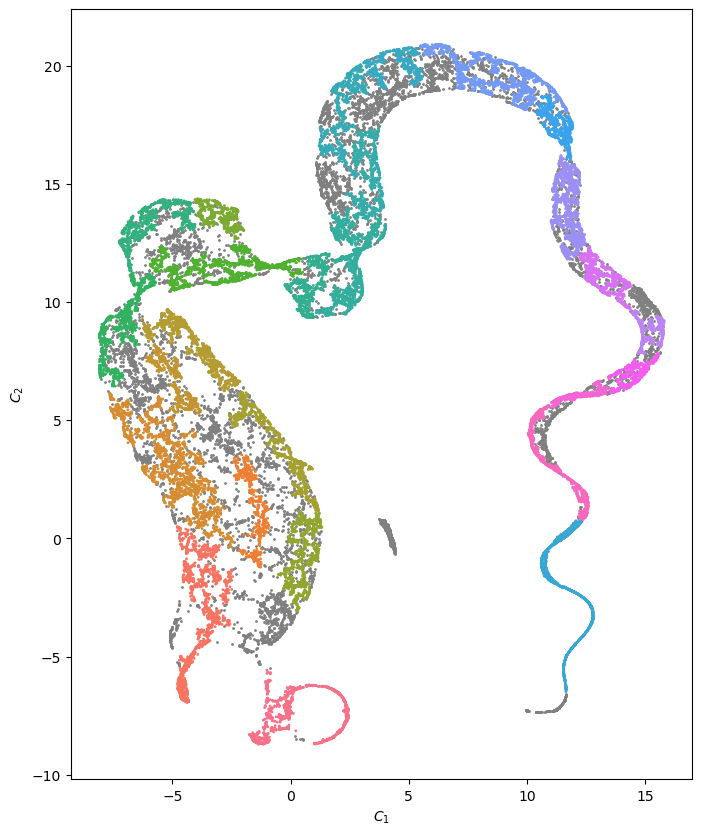

UMAP(min_dist=0.0, n_neighbors=28, random_state=42, verbose=True)
Tue Mar  5 18:14:06 2024 Construct fuzzy simplicial set
Tue Mar  5 18:14:06 2024 Finding Nearest Neighbors
Tue Mar  5 18:14:06 2024 Building RP forest with 15 trees
Tue Mar  5 18:14:06 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:14:07 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:14:07 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:14:45 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


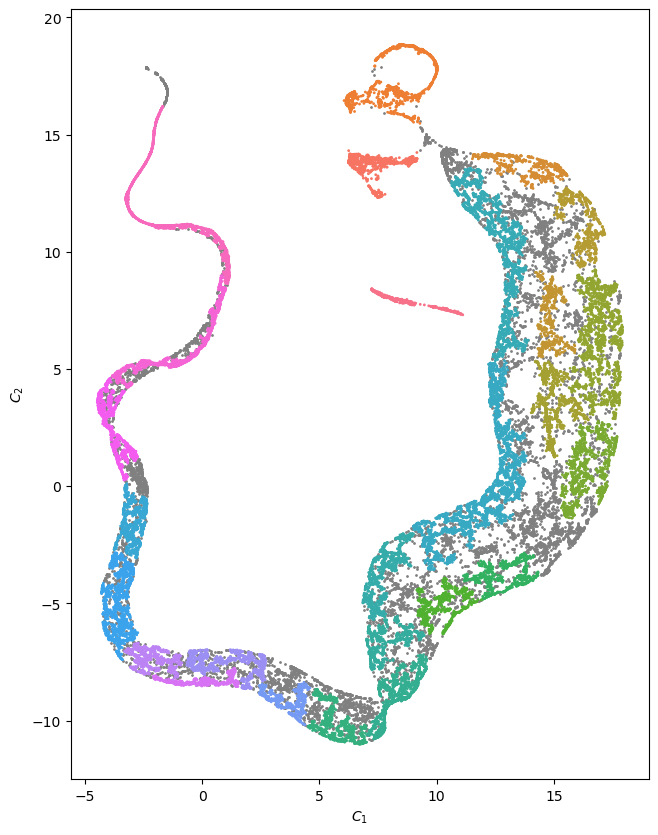

UMAP(min_dist=0.0, n_neighbors=30, random_state=42, verbose=True)
Tue Mar  5 18:14:48 2024 Construct fuzzy simplicial set
Tue Mar  5 18:14:48 2024 Finding Nearest Neighbors
Tue Mar  5 18:14:48 2024 Building RP forest with 15 trees
Tue Mar  5 18:14:48 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 18:14:49 2024 Finished Nearest Neighbor Search
Tue Mar  5 18:14:50 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 18:15:30 2024 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


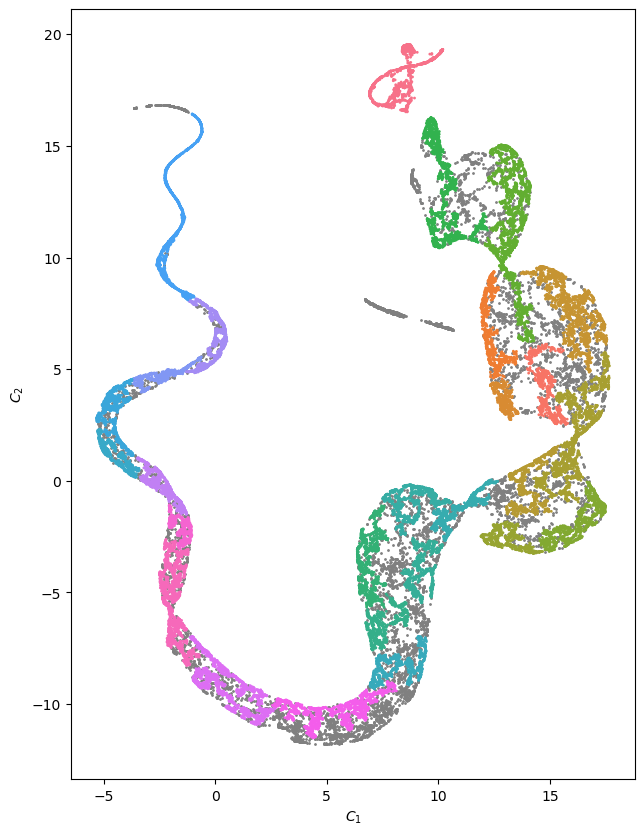

In [108]:
for nn in tqdm(n_neighbours):
    
    embedded_distances = umap.UMAP(
        n_neighbors=nn,
        min_dist=0.0,
        n_components=2,
        random_state=42,
        verbose=True,
    ).fit_transform(distances)
    
    np.save(output_embedded_distances.format(nn), embedded_distances)

    labels = hdbscan.HDBSCAN(
        min_samples=10,
        min_cluster_size=500,
        cluster_selection_method="leaf",
        cluster_selection_epsilon=0.1

    ).fit_predict(embedded_distances)
    
    np.save(output_cluster_labels.format(nn), labels)

    unique, counts = np.unique(labels, return_counts=True)
    pal = np.array(sns.color_palette("husl", unique.size))

    clustered = (labels >= 0)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.set_aspect("equal")

    # Plot noise in grey
    plt.scatter(embedded_distances[~clustered, 0],
                embedded_distances[~clustered, 1],
                c=(0.5, 0.5, 0.5),
                s=1,
                alpha=1)

    # Plot clusters by colour
    plt.scatter(embedded_distances[clustered, 0],
                embedded_distances[clustered, 1],
                c=pal[labels[clustered]],
                s=1,
                cmap='Spectral')

    plt.xlabel(r"$C_1$")
    plt.ylabel(r"$C_2$")

    plt.savefig(output_png.format(nn), format="png", dpi=300, bbox_inches="tight")
    plt.show()


## NN=24 looks good

In [10]:
input_embedded_distances = 'umap_files/NN_scan_step2/NN24_embedded_distances.npy'

output_embedded_distances = 'embedded_distances.npy'
output_cluster_labels = 'cluster_labels.npy'
output_png = 'clusters.png'

In [175]:
embedded_distances = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    verbose=True,
).fit_transform(distances)

# embedded_distances = umap.UMAP(
#     n_neighbors=20,
#     min_dist=0.1,
#     n_components=2,
#     random_state=42,
#     verbose=True,
# ).fit_transform(distances)


UMAP(n_neighbors=20, random_state=42, verbose=True)
Tue Mar  5 19:04:25 2024 Construct fuzzy simplicial set
Tue Mar  5 19:04:25 2024 Finding Nearest Neighbors
Tue Mar  5 19:04:25 2024 Building RP forest with 15 trees
Tue Mar  5 19:04:26 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	Stopping threshold met -- exiting after 2 iterations
Tue Mar  5 19:04:27 2024 Finished Nearest Neighbor Search
Tue Mar  5 19:04:27 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  5 19:05:06 2024 Finished embedding


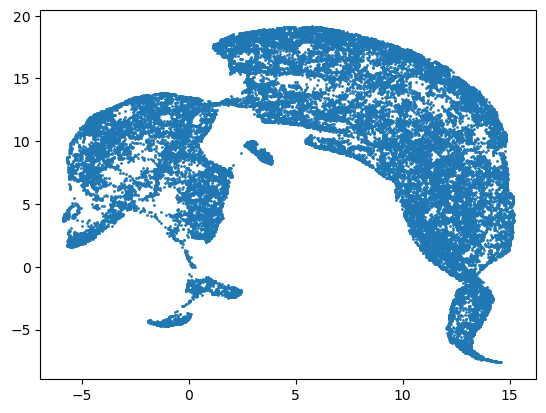

In [176]:
plt.scatter(embedded_distances[:, 0],
            embedded_distances[:, 1],
            # c=pal[labels[clustered]],
            s=1,
            cmap='Spectral')

In [21]:
embedded_distances.shape

(36383, 2)

In [22]:
distances.shape

(36383, 25)

In [144]:
nn = 24
labels = hdbscan.HDBSCAN(
    min_samples=16,  # min_samples 16 is fine
    min_cluster_size=1000,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=0.26,  # 0.245
).fit_predict(embedded_distances)

unique, counts = np.unique(labels, return_counts=True)

sort_counts = np.argsort(counts)
unique = unique[sort_counts][::-1]
counts = counts[sort_counts][::-1]

for u, c in zip(unique, counts):
    print(u, c)


2 32522
0 1414
-1 1304
1 1143


In [146]:
np.save(output_cluster_labels.format(20), labels)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


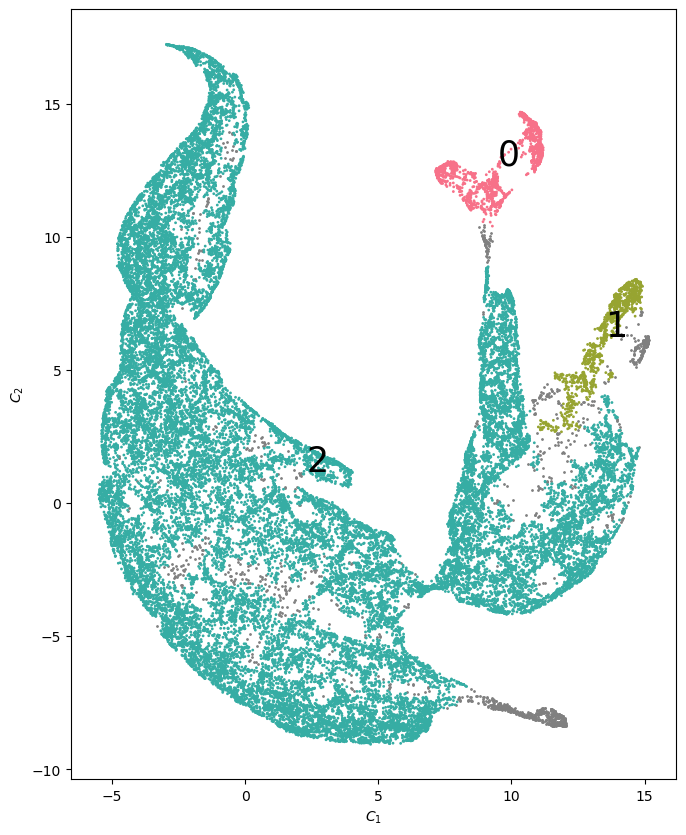

In [147]:
nn = 20
cluster_labels = np.load(output_cluster_labels.format(nn))
pal = np.array(sns.color_palette("husl", unique.size))

clustered = (labels >= 0)

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_aspect("equal")

# Plot noise in grey
plt.scatter(embedded_distances[~clustered, 0],
            embedded_distances[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=1,
            alpha=1)

# Plot clusters by colour
plt.scatter(embedded_distances[clustered, 0],
            embedded_distances[clustered, 1],
            c=pal[labels[clustered]],
            s=1,
            cmap='Spectral')

l = 3
start = 33013
end = 36383
# plt.scatter(embedded_distances[start + l:end:5, 0],
#             embedded_distances[start + l:end:5, 1],
#             c="red",
#             s=1)

for cluster in np.unique(cluster_labels):
    if cluster==-1:
        continue
    xy = np.mean(embedded_distances[cluster_labels==cluster], axis=0)
    plt.text(xy[0], xy[1], cluster, fontdict={"fontsize":25})

plt.xlabel(r"$C_1$")
plt.ylabel(r"$C_2$")

plt.savefig(output_png.format(nn), format="png", dpi=300, bbox_inches="tight")
plt.show()


In [52]:
embedded_distances

array([[-4.201556  ,  0.09156986],
       [-0.7531214 , 12.907411  ],
       [-4.8201504 , -3.7738621 ],
       ...,
       [ 7.346508  ,  1.0360961 ],
       [ 1.2792873 , -1.5485394 ],
       [-3.9166489 , -0.19847183]], dtype=float32)

In [103]:
labels[l:15330:21]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [81]:
label_chunks[0][:, 1]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       4, 5, 4, 4, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 6, 4, 5, 5, 4, 4, 4, 4, 5, 5,
       5, 4, 4, 4, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 5, 5, 4,
       4, 4, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5,

In [91]:
np.save("embedded_distances.npy", embedded_distances)
np.save("cluster_labels.npy", cluster_labels)

# Find representative conformations

In [5]:
embedded_distances = np.load("embedded_distances.npy")
cluster_labels = np.load("cluster_labels.npy")
distances = np.load(input_distances)


NameError: name 'input_distances' is not defined

In [17]:
p = [0, 730, 692, 601, 674]

# p[3] = 601

In [18]:
q = np.array([0, 21, 16, 11, 5])
p = np.array(p)

In [19]:
m = (q * p)
m = np.cumsum(m)

In [20]:
m

array([    0, 15330, 26402, 33013, 36383])

In [21]:
cluster_labels

array([2, 4, 2, ..., 6, 5, 2], dtype=int64)

In [22]:
label_chunks = []

for i in range(4):
    label_chunks.append(cluster_labels[m[i]: m[i + 1]])

In [23]:
for i, labels in enumerate(label_chunks):
    labels.shape = (p[i + 1], -1)
    

In [24]:
for i, labels in enumerate(label_chunks):
    print(labels.shape)

(730, 21)
(692, 16)
(601, 11)
(674, 5)


In [25]:
for res in label_chunks[0].T:
    print(f"{res[res != -1].std():.2f}")

0.62
0.33
0.33
0.00
0.00
0.15
0.00
0.00
0.08
0.00
0.40
0.45
0.07
0.22
1.02
0.15
0.13
0.95
0.06
0.04
0.00


In [26]:
for res in label_chunks[0].T:
    print(res[res != -1].std())

0.6180875959153624
0.3295794758288146
0.3333611672872716
0.0
0.0
0.1474115183815299
0.0
0.0
0.08265849228244157
0.0
0.4023471942038103
0.45364808467036327
0.07397260273972603
0.22493525078351514
1.0221867874736223
0.14764047764720525
0.1333841461943491
0.9498288751663801
0.06397421604841434
0.036986301369863014
0.0


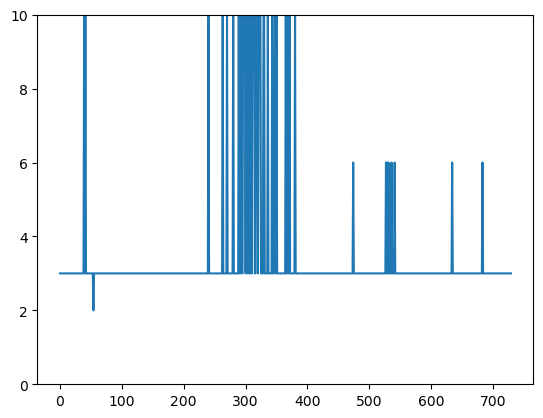

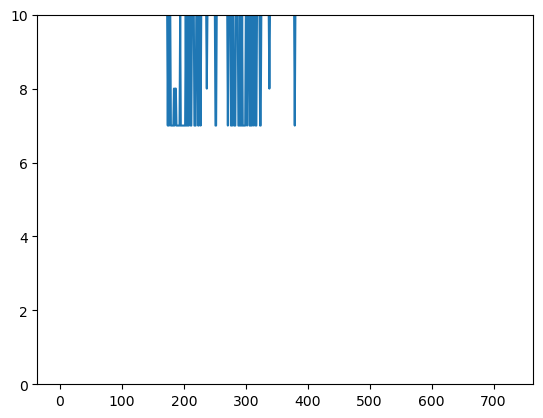

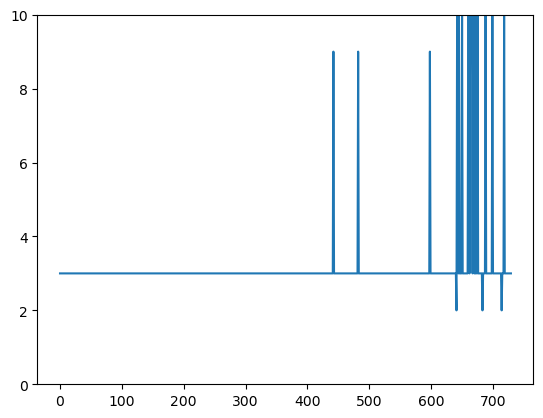

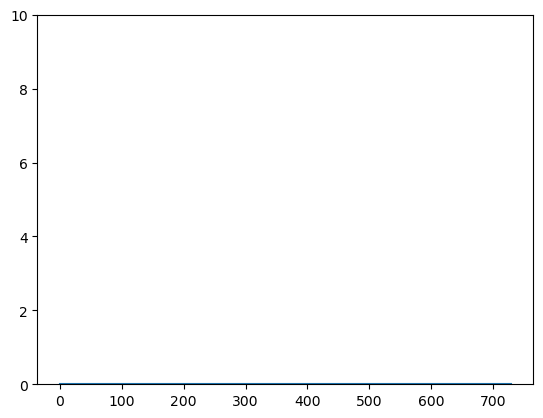

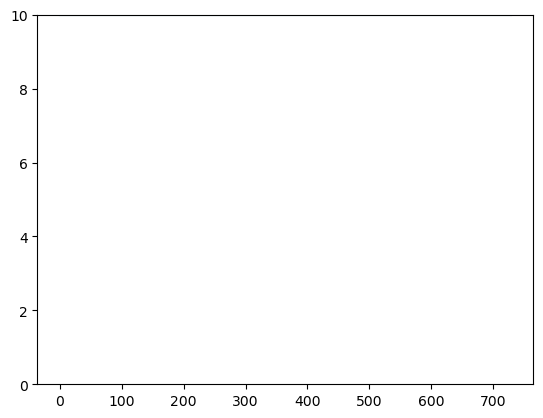

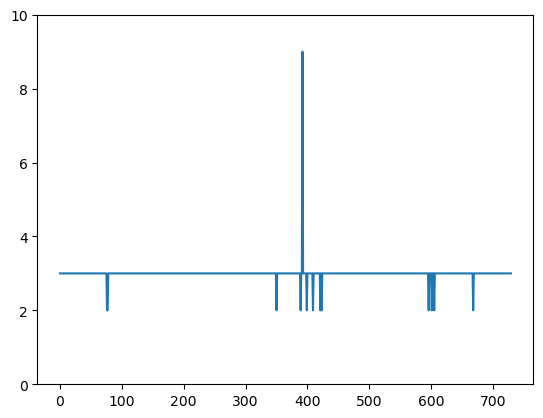

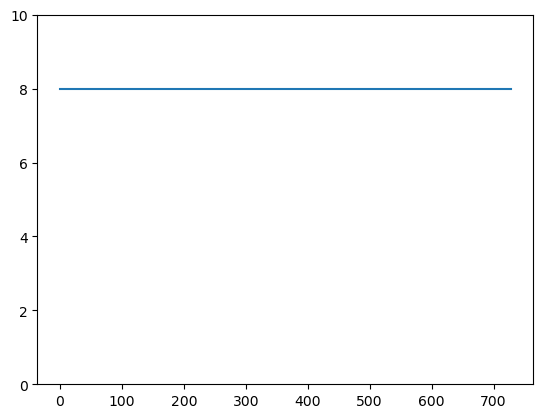

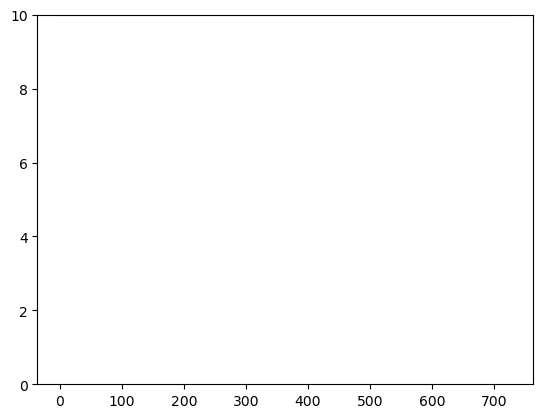

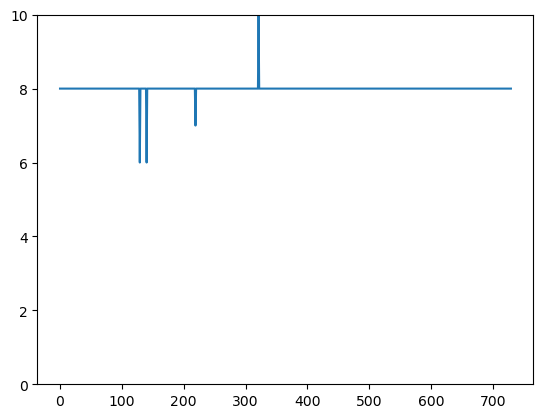

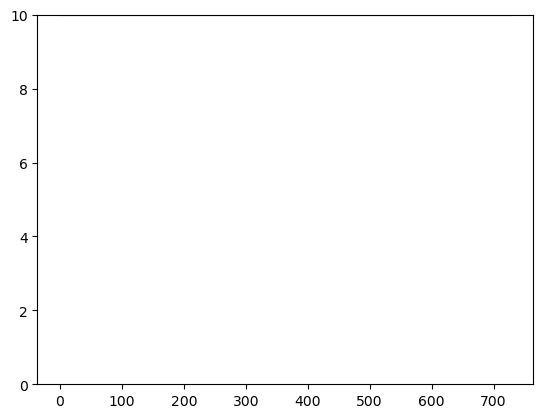

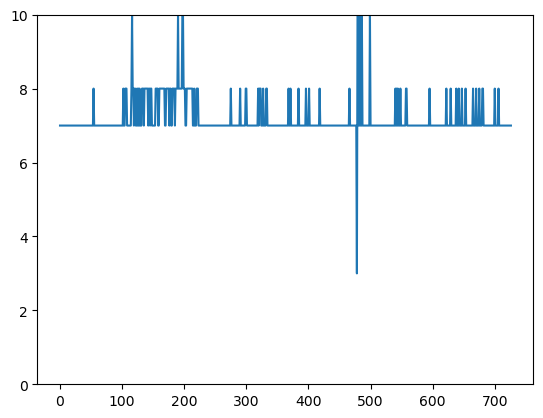

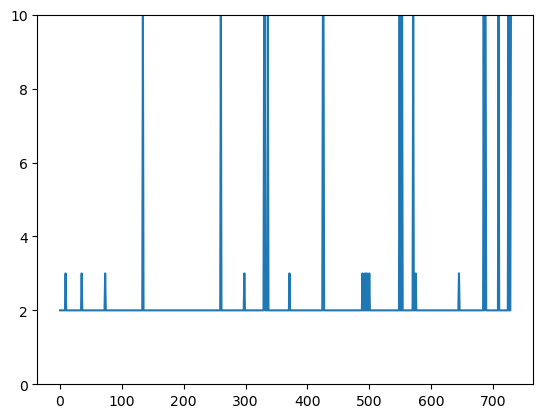

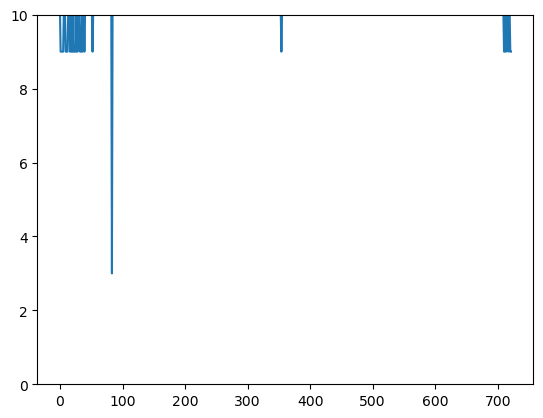

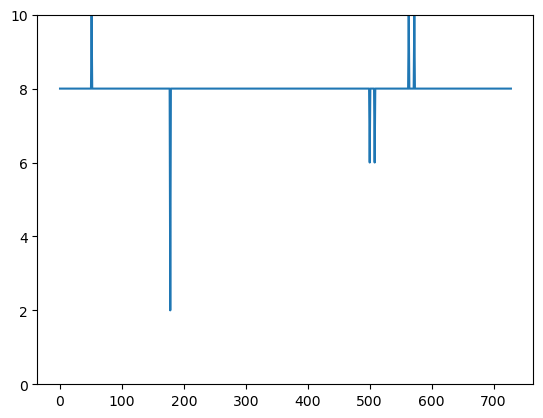

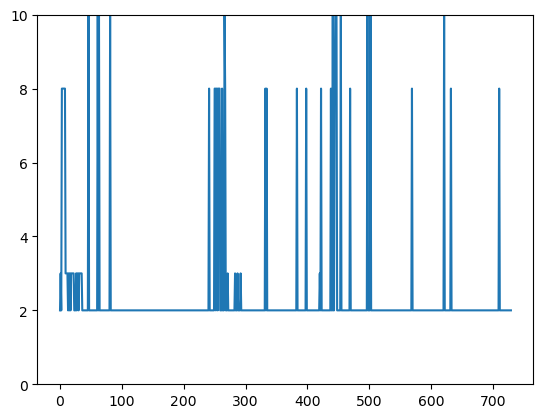

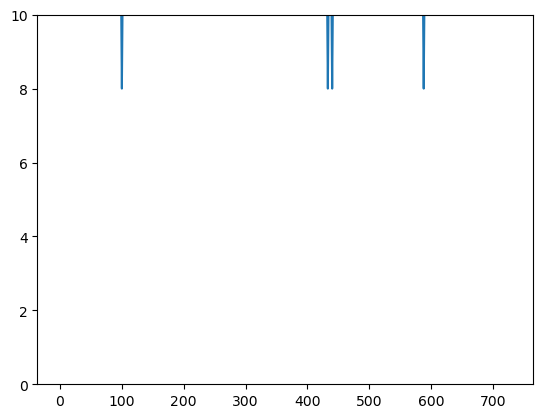

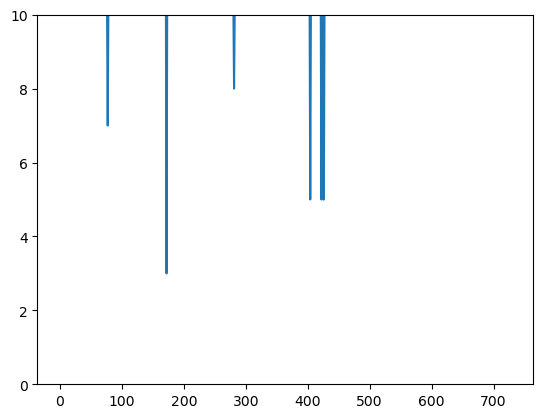

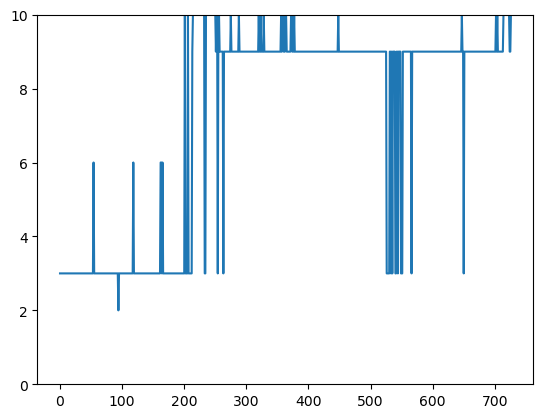

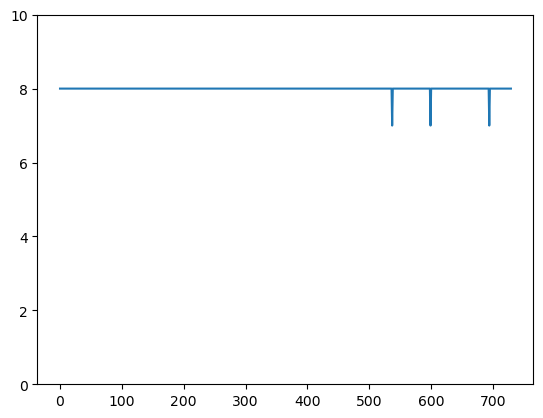

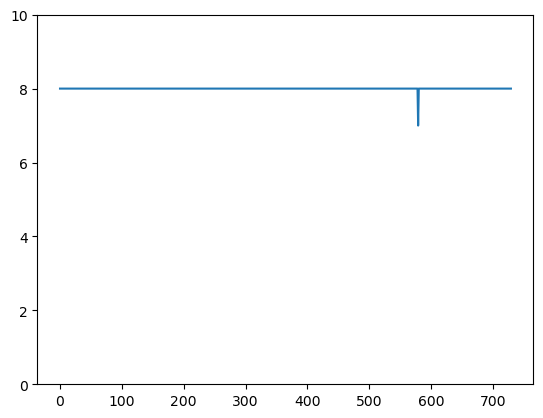

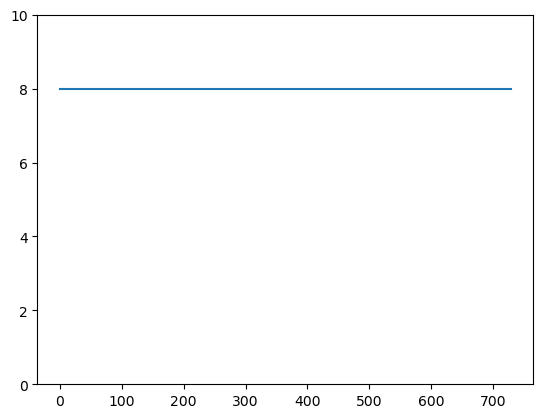

In [20]:
resid = 6
for res in label_chunks[0].T:
    plt.plot(res[res != -1])
    plt.ylim(0, 10)
    plt.show()
    # print(res)
    # label_chunks[2][np.where(label_chunks[2][:, resid - 1] != -1), resid - 1]

In [110]:
counts = np.bincount(label_chunks[0][:, 1])
print(np.argmax(counts))

ValueError: 'list' argument must have no negative elements

In [46]:
label_chunks[0][:, 1]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       4, 5, 4, 4, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 6, 4, 5, 5, 4, 4, 4, 4, 5, 5,
       5, 4, 4, 4, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 5, 5, 4,
       4, 4, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5,

In [135]:
val, counts = np.unique(label_chunks[1][:, 0], return_counts=True)

In [136]:
val[counts.argmax()]

3

In [27]:
for i, labels in enumerate(label_chunks):
    for j, l in enumerate(labels.T):
        val, counts = np.unique(l, return_counts=True)
        
        print(f"System: {i}, ", f"Residue: {j + 1:>2},", f"Conf: {val[counts.argmax()]:>4.2f}")

        # print(f"System: {i}, ", f"Residue: {j + 1:>2},", f"Conf: {l.mean(where=l != -1):>4.2f}")
    print("=" * 50)

System: 0,  Residue:  1, Conf: 2.00
System: 0,  Residue:  2, Conf: 4.00
System: 0,  Residue:  3, Conf: 2.00
System: 0,  Residue:  4, Conf: 0.00
System: 0,  Residue:  5, Conf: 4.00
System: 0,  Residue:  6, Conf: 2.00
System: 0,  Residue:  7, Conf: 6.00
System: 0,  Residue:  8, Conf: 4.00
System: 0,  Residue:  9, Conf: 6.00
System: 0,  Residue: 10, Conf: 4.00
System: 0,  Residue: 11, Conf: 5.00
System: 0,  Residue: 12, Conf: 1.00
System: 0,  Residue: 13, Conf: 4.00
System: 0,  Residue: 14, Conf: 6.00
System: 0,  Residue: 15, Conf: 1.00
System: 0,  Residue: 16, Conf: 4.00
System: 0,  Residue: 17, Conf: 4.00
System: 0,  Residue: 18, Conf: 4.00
System: 0,  Residue: 19, Conf: 6.00
System: 0,  Residue: 20, Conf: 6.00
System: 0,  Residue: 21, Conf: 6.00
System: 1,  Residue:  1, Conf: 2.00
System: 1,  Residue:  2, Conf: 0.00
System: 1,  Residue:  3, Conf: 4.00
System: 1,  Residue:  4, Conf: 2.00
System: 1,  Residue:  5, Conf: 6.00
System: 1,  Residue:  6, Conf: 6.00
System: 1,  Residue:  7, Con

In [15]:
len(np.unique(label_chunks[0].mean(axis=0).round()))

7

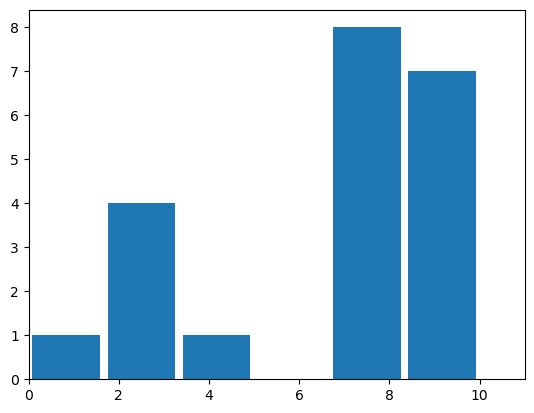

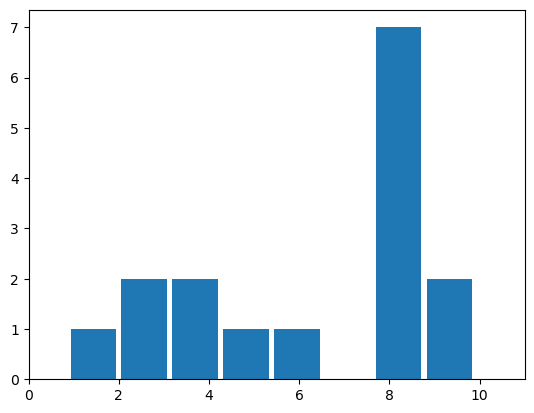

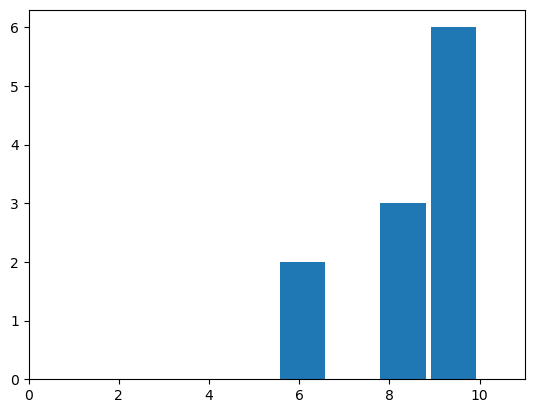

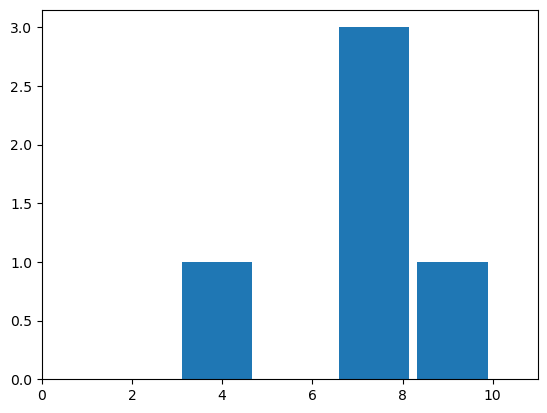

In [104]:
for i in range(4):
    n_bins = len(np.unique(label_chunks[i].mean(axis=0).round()))
    plt.hist(label_chunks[i].mean(axis=0), bins=n_bins, rwidth=0.9)
    plt.xlim(0, 11)
    plt.show()

## Hist

In [12]:
flattened_dists = result[result != 0].flatten()

(array([120236.,  84350.,  20916.,  28858.,  52626.,  72050.,  19120.,
         20502.,  15864.,   2074.]),
 array([ 5.59778443,  7.512987  ,  9.42818958, 11.34339216, 13.25859474,
        15.17379732, 17.0889999 , 19.00420248, 20.91940506, 22.83460764,
        24.74981022]),
 <BarContainer object of 10 artists>)

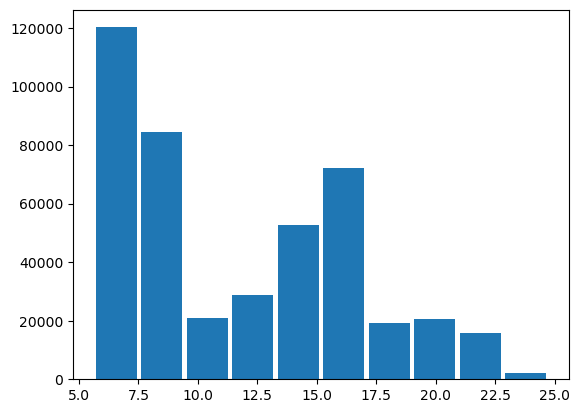

In [13]:
plt.hist(flattened_dists, rwidth=0.9)

In [14]:
flattened_dists.min()

5.597784425327617

In [73]:
input_distances = f"{directory}/{SYSTEM_NAME}/tyl_100_distances.npy"
input_embedded_distances = 'embedded_distances.npy'
input_cluster_labels = 'cluster_labels.npy'

output_conformations = 'conformations.txt'
output_png = "umap_files/distance_maps/distance_map_cluster_{}.png"

In [74]:
distances = np.load(input_distances)

In [75]:
embedded_distances = np.load(input_embedded_distances)
cluster_labels = np.load(input_cluster_labels)

In [76]:
conformations = []

cluster_ids = np.unique(cluster_labels)
for cluster in cluster_ids:

    # Dont find the conformation for the noise (unclustered points)
    if cluster == -1:
        continue
    
    cluster_indices = np.where(cluster_labels==cluster)[0]
    cluster_distances = embedded_distances[cluster_indices]
    average_structure = np.mean(cluster_distances, axis=0)
    rmsds = np.sqrt(np.mean(np.square((average_structure - cluster_distances)), axis=1))
    min_rmsd_index = np.where(rmsds == np.min(rmsds))[0][0]
    
    conformations.append([cluster, cluster_indices[min_rmsd_index]])
    
conformations = np.array(conformations)


In [77]:
np.savetxt(output_conformations, conformations, fmt="%.0d")

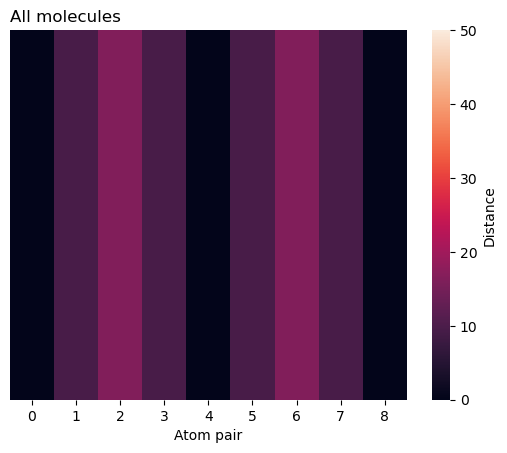

In [78]:
sns.heatmap(
    np.mean(distances, axis=0)[:,None].T,
    cbar_kws={"label":"Distance"},
    square=False,
    vmin=0,
    vmax=50,
)

plt.yticks([])
plt.xlabel("Atom pair")
plt.title(f"All molecules", loc="left")
plt.savefig("distance_map_all_molecules.png", format="png", bbox_inches="tight")


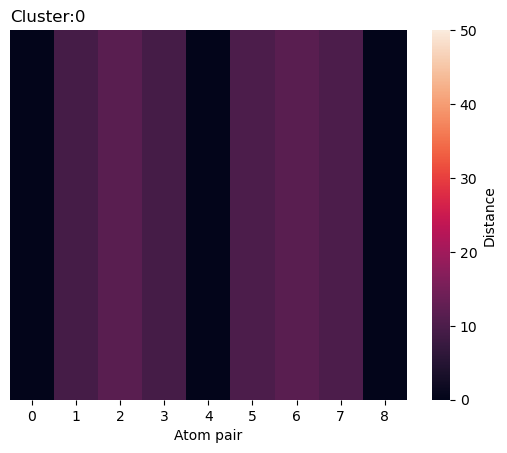

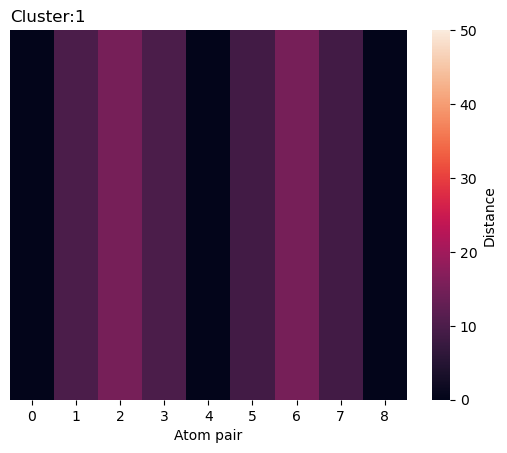

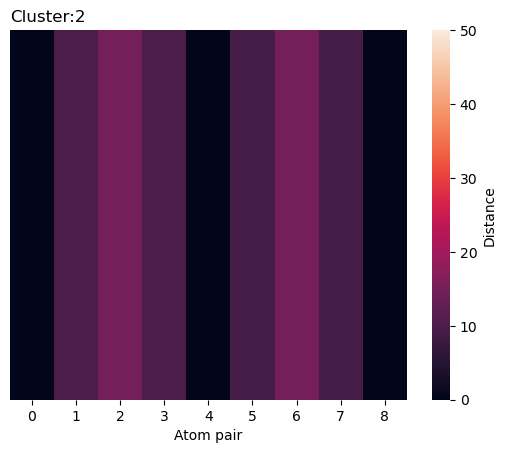

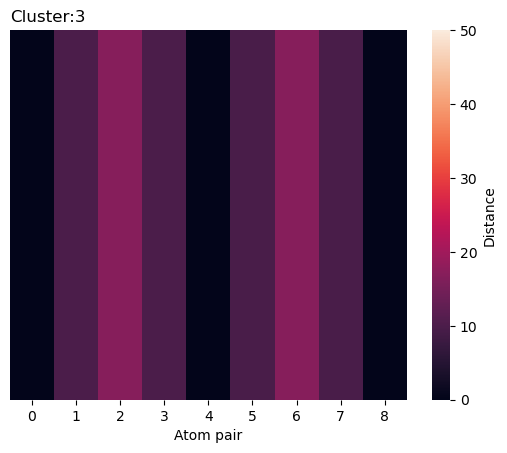

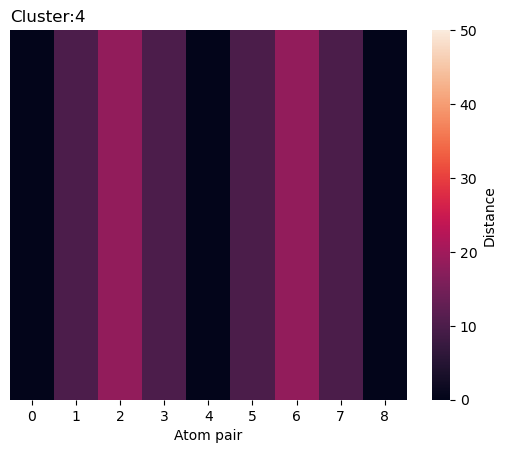

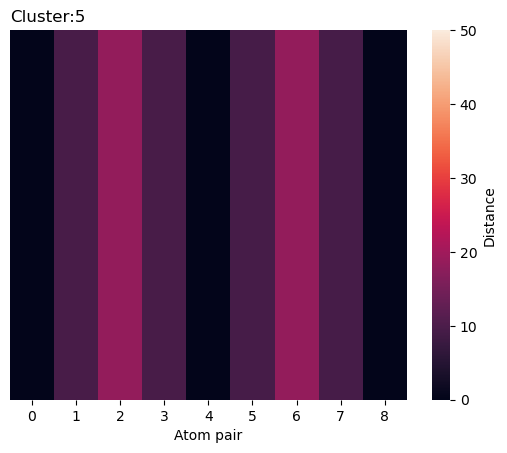

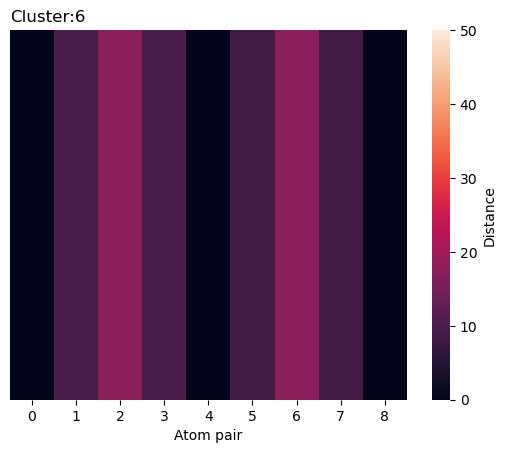

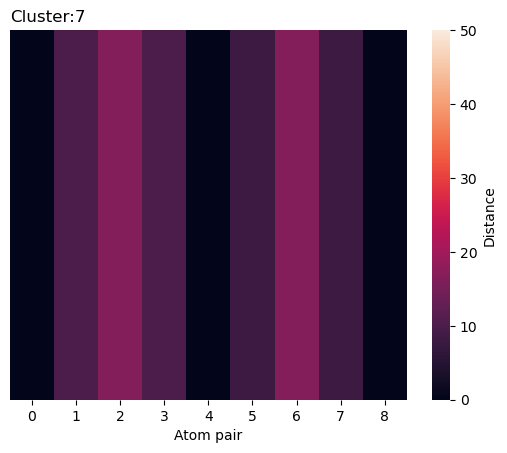

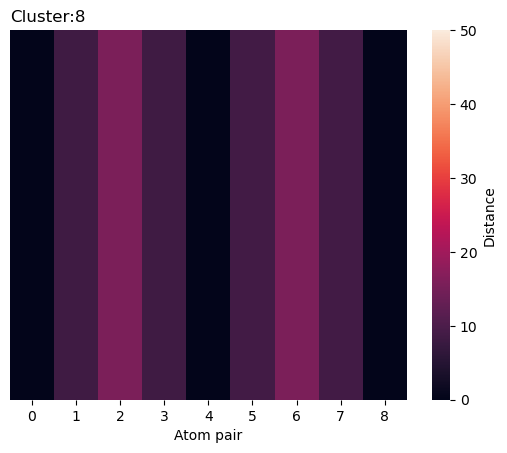

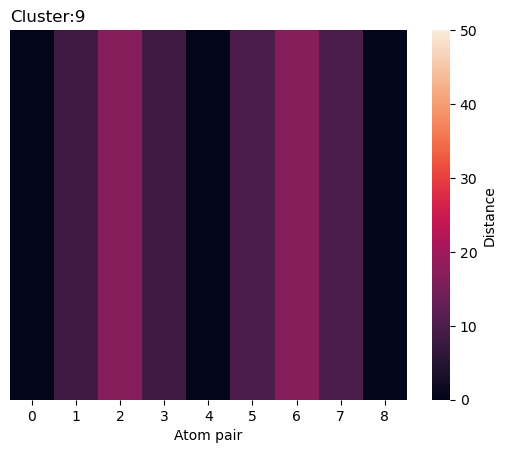

In [79]:
for conformation in conformations:
    
    sns.heatmap(
        distances[conformation[1],None],
        cbar_kws={"label":"Distance"},
        square=False,
        vmin=0,
        vmax=50,    
    )
    plt.xlabel("Atom pair")
    plt.yticks([])
    plt.title(f"Cluster:{conformation[0]}", loc="left")
    plt.savefig(output_png.format(conformation[0]), format="png", bbox_inches="tight")
    plt.show()

    
        